<a href="https://colab.research.google.com/github/TheBlackRus/liveproject_HumanPoseEstimation/blob/master/liveproject_humanpose_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torchvision
import torch

In [2]:
# This code downloads the coco dataset from Amazon S3 in parallel.
import boto3
from botocore import UNSIGNED
from botocore.client import Config
import multiprocessing
import subprocess
files = ['val2017.zip', 'annotations_trainval2017.zip']#, 'train2017.zip']

s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
def download_and_unzip_from_s3(file_name, bucket_name='fast-ai-coco'):
    print("Downloading", file_name)
    s3.download_file(bucket_name, file_name, file_name)
    print("Finished downloading", file_name, ". Starting to unzip.")
    subprocess.run(["unzip", file_name])
    print("Finished unzipping", file_name)

# Download in parallel
num_cpus = multiprocessing.cpu_count()
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_and_unzip_from_s3, files)

print("Done transferring all datasets")

Finished downloading annotations_trainval2017.zip . Starting to unzip.
Finished downloading val2017.zip . Starting to unzip.
Finished unzipping annotations_trainval2017.zip
Finished unzipping val2017.zip
Done transferring all datasets


In [0]:
# read the meta data of the validation set
import json
file_name = "annotations//person_keypoints_val2017.json"
with open(file_name, 'r') as json_raw:
    meta = json.load(json_raw)

In [0]:
example = 0
img_info = meta["images"][example]
img_annotation = meta["annotations"][example]
img_catogory = meta["categories"][0]["keypoints"]

In [5]:
img_file = str(img_annotation["image_id"])
img_file = img_file.zfill(12) +".jpg" #img_info["file_name"]
print(img_file, img_annotation["image_id"])

000000425226.jpg 425226


In [0]:
def resize_image(img, target_width=192, target_height=256):
  img_resized = cv2.resize(img,(target_width,target_height))
  return img_resized

def crop_image(img, upper_left_corner, size):
  start_x, start_y = upper_left_corner
  w,h = size
  img_cropped = img[int(start_y):(int(start_y+h)),int(start_x):int(start_x+w),:]
  return img_cropped

def adjust_keypoint(keypoint, start, scale):
  keypoint_x, keypoint_y= keypoint
  start_x,start_y = start
  sx,sy = scale
  x = (keypoint_x-start_x)*sx
  y = (keypoint_y-start_y)*sy
  return x,y


In [0]:
%matplotlib inline
#from matplotlib.pyplot import imshow
from matplotlib import image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

In [0]:
img = image.imread("val2017//"+img_file)
img = img / 255.0

In [10]:
img_batch = torch.Tensor([img, img])
print(img_batch.shape)
img_batch = img_batch.permute([0,3,2,1])
img_batch.shape

torch.Size([2, 640, 480, 3])


torch.Size([2, 3, 480, 640])

In [0]:
img_batch.max()
img_batch = img_batch.cuda()

In [12]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.cuda()
model.eval()

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace=True)
          (downsample): Sequent

In [15]:
y = model(img_batch)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


In [16]:
y

[{'boxes': tensor([[212.5397,  64.2023, 563.9282, 358.7718],
          [355.1589, 226.9010, 394.5103, 299.8187],
          [389.6106,  89.7069, 565.4318, 280.4237],
          [ 31.8342, 141.2249, 331.9860, 406.0846],
          [505.8641, 118.0132, 577.4388, 238.9388],
          [ 48.9423,  52.3993, 567.9708, 441.1093],
          [269.1020, 288.9832, 305.5331, 314.1668],
          [236.7639, 178.1634, 305.9442, 259.8866],
          [227.3062, 120.0427, 242.7734, 138.9593],
          [338.5215, 220.8336, 377.9923, 313.5775],
          [187.0308,  13.4958, 254.0475,  83.2915],
          [197.4345, 300.9328, 606.9046, 453.8034],
          [365.9975, 226.3491, 393.0796, 276.2737],
          [339.6570, 226.1735, 356.4973, 312.2776],
          [296.6670, 292.5830, 333.8354, 310.4262],
          [ 48.6918, 261.7969, 128.5480, 354.0468],
          [ 64.2551,  53.7829, 594.8115, 415.7347],
          [284.8063, 285.2485, 445.4222, 315.1196],
          [232.7171, 141.9245, 239.5738, 164.5803],
   

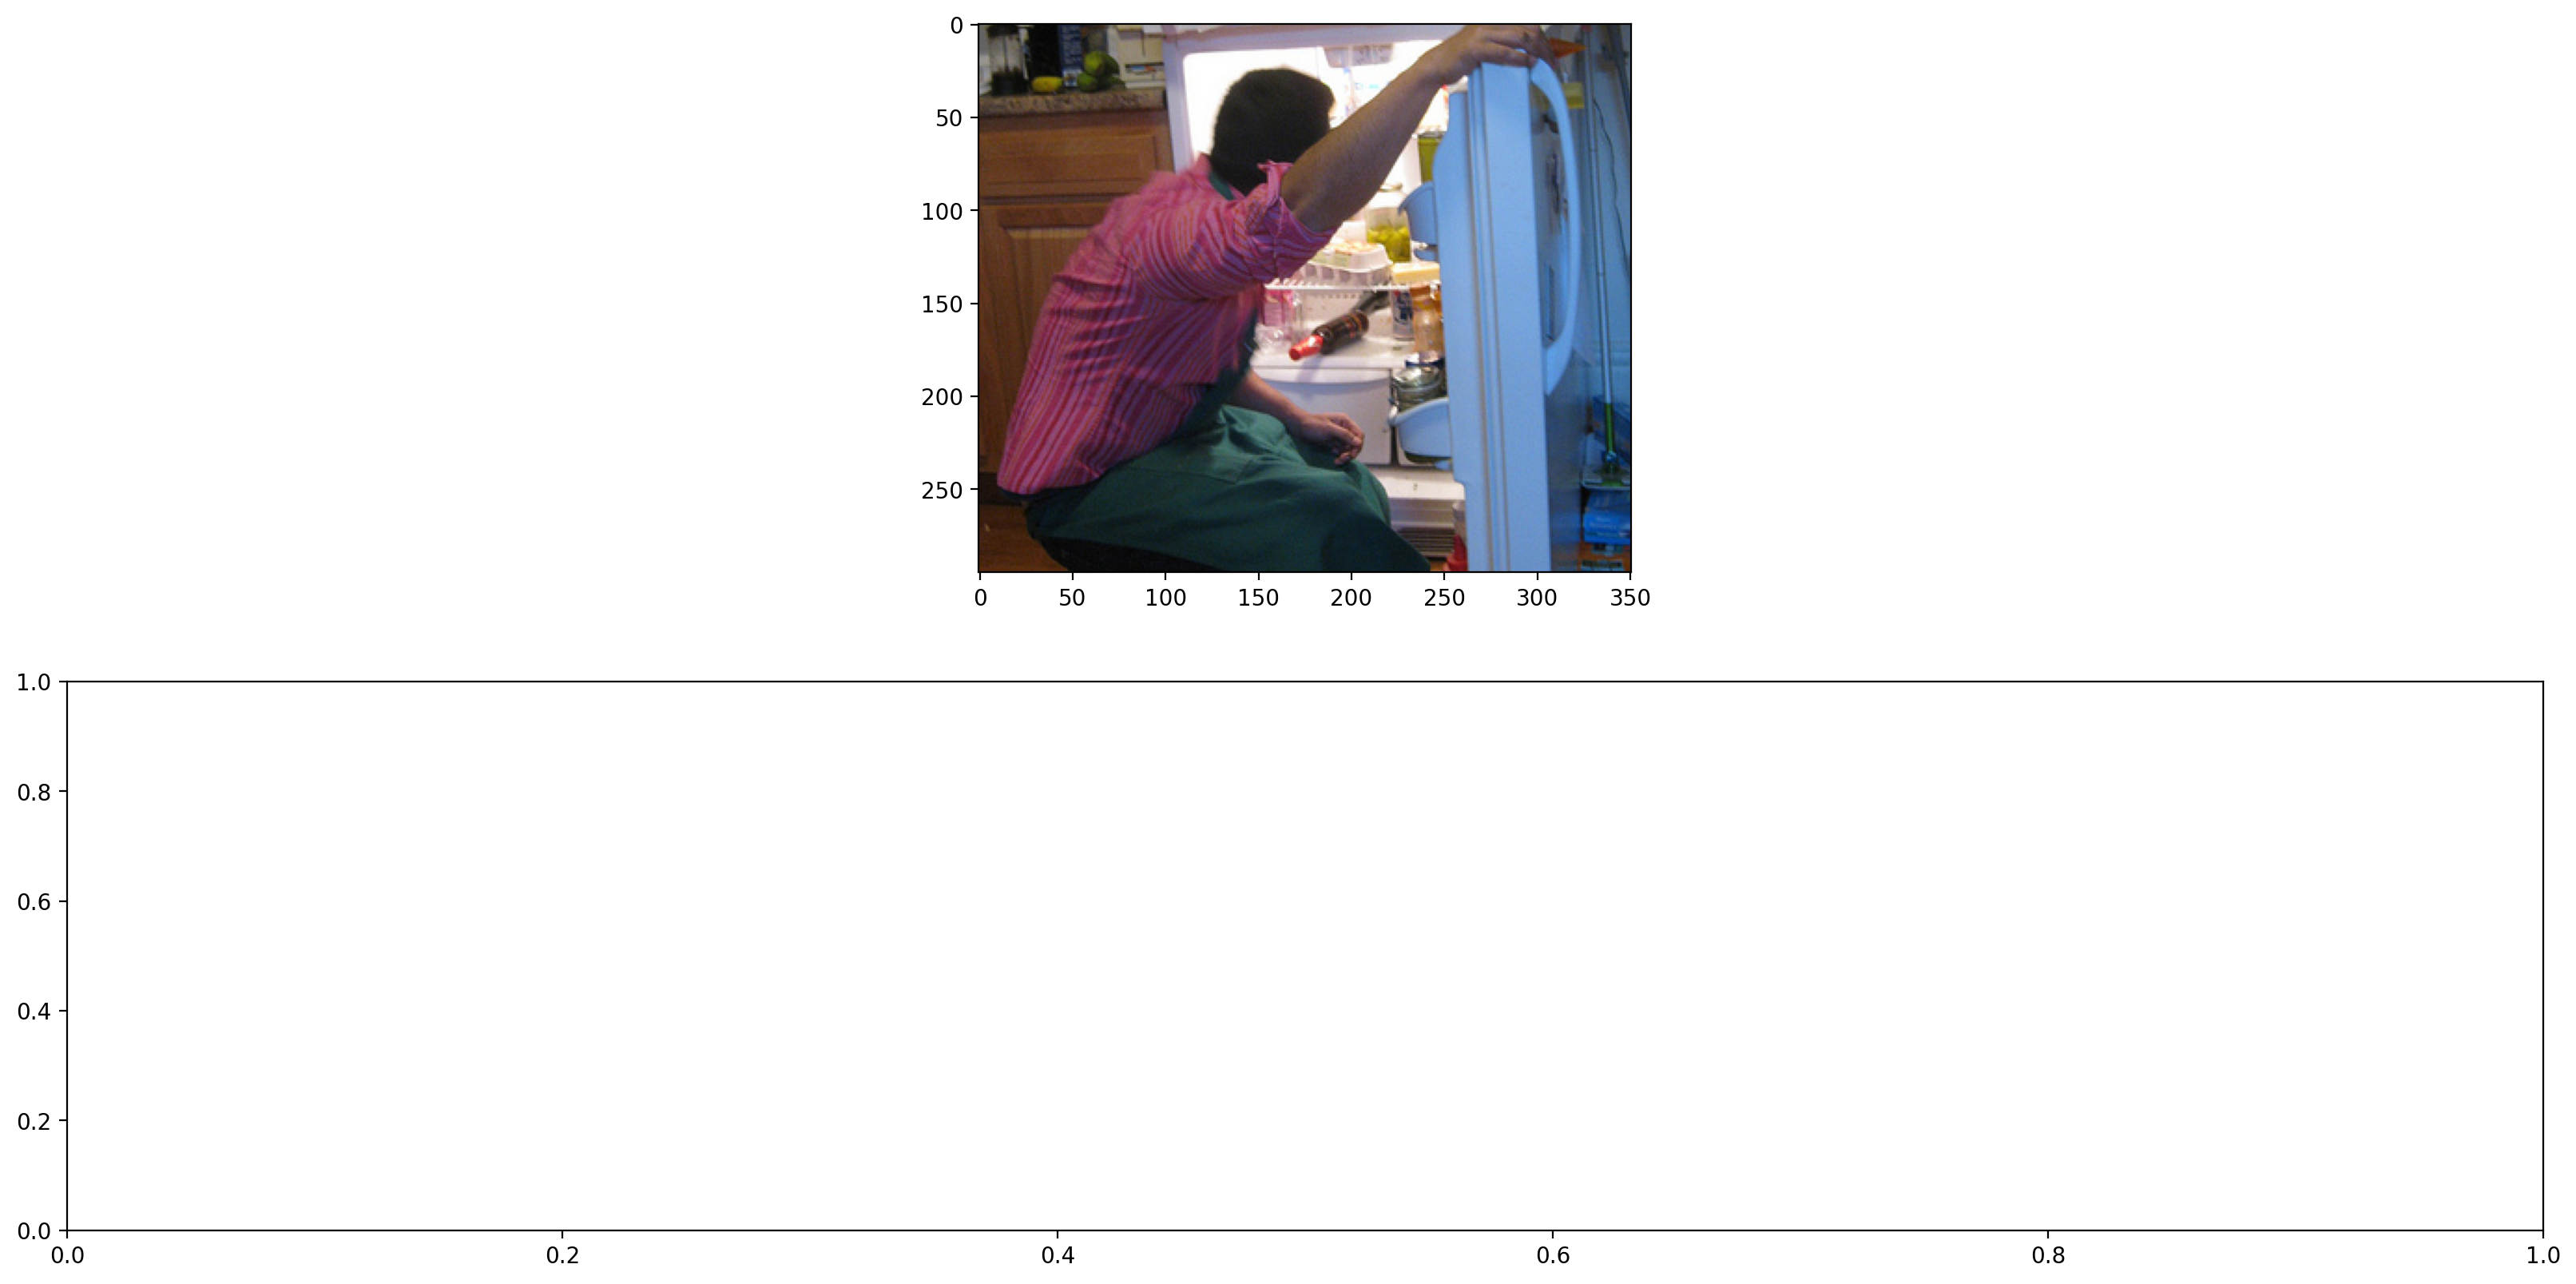

In [29]:
box = y[0]["boxes"][0]
crop_img = crop_image(img,(box[1],box[0]),(box[2]-box[0],box[3]-box[1]))

fig,ax = plt.subplots(2,figsize=(20,10))
fig.set_dpi(200)
ax[0].imshow(crop_img)
plt.show()

In [5]:

# For training
images, boxes = torch.rand(4, 3, 600, 1200), torch.rand(4, 11, 4)
labels = torch.randint(1, 91, (4, 11))
images = list(image for image in images)
targets = []
for i in range(len(images)):
    d = {}
    d['boxes'] = boxes[i]
    d['labels'] = labels[i]
    targets.append(d)
output = model(images, targets)
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)

# optionally, if you want to export the model to ONNX:
torch.onnx.export(model, x, "faster_rcnn.onnx", opset_version = 11)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)
/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python)